<a href="https://colab.research.google.com/github/peterbmob/DHMVADoE/blob/main/phase_diagram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimate density from binary phase diagram

In [1]:
!pip install bayesian-optimization

In [3]:
!pip install ase

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.9 MB/s eta 0:00:00


In [7]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
import numpy as np

import ase
from ase import phasediagram
from ase.calculators import emt
from ase.visualize import view
from ase import optimize
import random


import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

In [5]:
class Tpsd(optimize.optimize.Optimizer):
  """Two-point steepest descent optimiser.  Optimises both the atomic
  coordinates and the unit cell
  """
  def __init__(self, atoms, restart=None, logfile='-', trajectory=None,
               master=None):
    super().__init__(atoms, restart, logfile, trajectory, master)
    self.delta_pos = np.zeros(atoms.positions.shape)

    self.f0 = np.ones(atoms.positions.shape)
    self.delta_force = np.zeros(atoms.positions.shape)

    self.pressure = 0.0001
    self.pressure_mtx = np.zeros((3, 3))
    np.fill_diagonal(self.pressure_mtx, self.pressure)
    self.delta_lattice = np.zeros((3, 3))

    self.s0 = np.zeros((3, 3))
    self.stepsize = 0.001
    self.stress_max = 0.001
    self.residual_stress = None

  def step(self, f=None):
    atoms = self.atoms

    cell_mtx = atoms.get_cell()[:]
    stress_mtx = atoms.get_stress(voigt=False)
    forces = atoms.get_forces()

    s = np.matmul(-stress_mtx, cell_mtx)
    # H = U + pV
    h = atoms.get_potential_energy() + self.pressure * atoms.get_volume() # Enthalpy

    # Calculate differences since last step
    delta_force = forces - self.f0
    delta_s = s - self.s0

    xg = np.sum(np.multiply(self.delta_pos, delta_force)) + np.sum(np.multiply(self.delta_lattice, delta_s))
    gg = np.sum(np.multiply(delta_force, delta_force)) + np.sum(np.multiply(delta_s, delta_s))

    if (abs(xg) > 0):
      self.stepsize = abs(xg / gg)

    # Move the positions
    self.delta_pos = self.stepsize * forces
    atoms.set_positions(atoms.positions + self.delta_pos)

    # Move the unit cell
    self.residual_stress = stress_mtx + self.pressure_mtx
    self.delta_lattice = self.stepsize * np.matmul(-self.residual_stress, cell_mtx)
    atoms.set_cell(cell=cell_mtx + self.delta_lattice, scale_atoms=True)

    atoms.wrap()

    # Save things for next step
    self.f0 = forces
    self.s0 = s

  def converged(self, forces=None):
    if self.residual_stress is not None:
      residual_pressure = self.residual_stress.max()
      if residual_pressure > self.stress_max:
        return False

    return super().converged(forces=forces)

# The calculator
calc = emt.EMT()

def get_random_cell(length_range: tuple, angle_range: tuple):
  """Return random lattice parameters within the given ranges"""
  return (
      random.uniform(*length_range), # a
      random.uniform(*length_range), # b
      random.uniform(*length_range), # c
      random.uniform(*angle_range), # alpha
      random.uniform(*angle_range), # beta
      random.uniform(*angle_range) # gamma
  )

def scale(atoms: ase.Atoms, volume: float):
  """Scale an atoms object to a given target volume"""
  factor = (volume / atoms.get_volume())**(1/3)
  atoms.set_cell(cell=atoms.get_cell() * factor)
  return atoms

In [99]:
# 1. Get a random unit cell with 'reasonable' parameters
# (see https://wiki.fysik.dtu.dk/ase/index.html for explanations)
cell = get_random_cell((20, 25), (80, 110))
atoms = ase.Atoms(pbc=True, cell=cell)

# 2. Now, decide how many atoms you want in your unit cell, we find that 18A^3
# per atoms is a decent starting volume but feel free to play around.  Maybe
# look up existing calculations on www.materialsproject.com??? or any other
# database for materials science.
NUM_ATOMS = 4
atoms = scale(atoms, NUM_ATOMS * 18)

# 3. Put atoms in your atoms object
species = ('Au', 'Al')
for _ in range(NUM_ATOMS):
  atoms.append(ase.Atom(random.choice(species))) # Notice we don't set the position

# 4. Randomise the starting positions of the atoms, have a look at the rattle()
# method of Atoms, here: https://wiki.fysik.dtu.dk/ase/ase/atoms.html#ase.Atoms.rattle
# for one way to do this. Make sure to choose a large enough standard deviation
# that your atoms can be almost anywhere in the cell
atoms.rattle(20)

# We'll wrap the coordinates in case some cartesian coordinates went outside the cell
atoms.wrap()

# 5. Attach the emt calculator to the atoms object, have a look at the last
# exercise for how to do this
atoms.calc = emt.EMT()

# Now, let's call the optimiser and minimise the atomic positions
opt = Tpsd(atoms)
opt.run(fmax=0.01)  # unit of force is eV/Å

# You can also have a look at the optimized structure, does it look OK?
#view(atoms) #, viewer='x3d')

# Can you develop a new strategy/algorithm which is more efficient in finding low energy structures?

      Step     Time          Energy         fmax
Tpsd:    0 10:46:04       71.755608      399.1026
Tpsd:    1 10:46:04       99.856561      105.3426
Tpsd:    2 10:46:04       70.681103      110.5803
Tpsd:    3 10:46:04       21.242890       75.5936
Tpsd:    4 10:46:04        6.683478       14.5674
Tpsd:    5 10:46:04        4.507529        5.3788
Tpsd:    6 10:46:04        3.868470        2.7382
Tpsd:    7 10:46:04        3.514752        2.2281
Tpsd:    8 10:46:04        3.094789        2.0717
Tpsd:    9 10:46:04        2.366471        1.5243
Tpsd:   10 10:46:04        1.858690        0.7445
Tpsd:   11 10:46:04        1.606223        0.6576
Tpsd:   12 10:46:04        1.421665        0.5616
Tpsd:   13 10:46:05        1.295858        0.5073
Tpsd:   14 10:46:05        1.202221        0.4575
Tpsd:   15 10:46:05        1.116924        0.4216
Tpsd:   16 10:46:05        0.980019        0.3991
Tpsd:   17 10:46:05        0.715461        0.3479
Tpsd:   18 10:46:05        0.682157        0.7916
T

True

In [94]:
atoms

Atoms(symbols='Al2Au2', pbc=True, cell=[[4.885748169805635, 0.573397671511808, 0.004838888467572465], [1.0060652841268694, 4.880459906131843, -0.16035573211084433], [-0.014745050196845948, 0.09646173997481242, 2.8620123151139407]], calculator=EMT(...))

In [12]:
from ase.phasediagram import PhaseDiagram


In [35]:
refs=[('Al',0.0), ('Au', 0.0)]

In [100]:
refs.append((atoms.get_chemical_formula(),atoms.get_total_energy()))

In [101]:
refs

[('Al', 0.0),
 ('Au', 0.0),
 ('AlAu3', -0.0472893200349489),
 ('Al2Au3', -0.09230338630035106),
 ('AlAu2', -0.05374793660957522),
 ('AlAu', -0.030032179485678157),
 ('Al4', -0.019513304874882564),
 ('Al2Au2', -0.1332019554578725),
 ('Al2Au2', -0.061571771536973685)]

In [97]:
pd=PhaseDiagram(refs)

Species: Al, Au
References: 8
0    Al             0.000
1    Au             0.000
2    AlAu3         -0.047
3    Al2Au3        -0.092
4    AlAu2         -0.054
5    AlAu          -0.030
6    Al4           -0.020
7    Al2Au2        -0.133
Simplices: 2


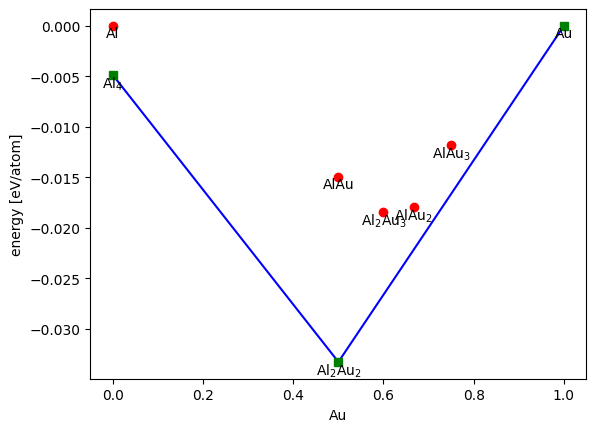

<Axes: xlabel='Au', ylabel='energy [eV/atom]'>

In [102]:
pd.plot(show=True)

In [77]:
from ase.db import connect
from ase.io import read, write

db = connect('my_db.db')

In [103]:
db.write(atoms)

6

In [132]:
import pandas as pd
features_from_atoms=pd.DataFrame({})
symbols=[]; energy=[]; density=[]; com=[]; conc_Au=[]; average_dist=[]


for row in db.select():
  atoms=row.toatoms()
  symbols.append(atoms.get_chemical_formula())

  energy.append(row.energy)
  atoms.get_volume()
  sum(atoms.get_masses())
  density.append(atoms.get_volume()/sum(atoms.get_masses()))

  com.append(sum(atoms.get_center_of_mass()))
  nlist= atoms.get_chemical_symbols()
  conc_Au.append(nlist.count('Au')/(nlist.count('Au')+nlist.count('Al')))

  average_dist.append(sum(sum(atoms.get_all_distances()))/len(nlist)**2)


features_from_atoms['symbols']=symbols
features_from_atoms['energy']=energy
features_from_atoms['denisty']=density
features_from_atoms['com']=com
features_from_atoms['conc_Au']=conc_Au
features_from_atoms['average_dist']=average_dist




features_from_atoms

,symbols,energy,denisty,com,conc_Au,average_dist
0,AlAu3,-0.047289,0.108154,5.896651,0.750000,2.152098
1,Al2Au3,-0.092303,0.129751,4.982349,0.600000,2.729840
2,AlAu2,-0.053748,0.119298,5.906825,0.666667,1.913362
3,AlAu,-0.030032,0.149383,2.396496,0.500000,1.476097
4,Al2Au2,-0.133202,0.148853,5.909866,0.500000,2.294519
5,Al2Au2,-0.061572,0.149312,4.778794,0.500000,2.152740
